Machine larning models for the Estimation of obesity levels based on eating habits and physical condition Data Set. We will try to fit the models with a preprocessing to have the target feature with 3 and 4 categories. For each one, we will try to fit the models with all the features and dropping the 3 less important features.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Load and preprocess data

First we use only 4 categories of the target feature. For the way of transport we use 3 categories (as we explain in the exploratory data analysis). One hot encoding for the way of transport and an ordinal encoder for the rest of categorical features. We don't use weight and height.

In [2]:
# Load the data
data = pd.read_csv('./ObesityDataSet_raw_and_data_sinthetic.csv').drop(['Weight', 'Height'], axis = 1)

# Rename data
data = data.rename(columns = {'family_history_with_overweight': 'Family_overweight', 'FAVC': 'High_cal_food', 
                              'FCVC': 'Vegetables', 'NCP': 'Number_meals', 'CAEC': 'Eat_between_meals', 'SMOKE': 'Smoke', 
                              'CH2O': 'Water', 'CALC': 'Alcohol', 'SCC': 'Calories_monitoring', 'FAF': 'Exercise_time', 
                              'TUE': 'Technologies_time', 'MTRANS': 'Transport_way'})

# Round numerical variables
columns = ['Vegetables', 'Water', 'Exercise_time', 'Technologies_time', 'Number_meals']
for col in columns:
    data[col] = round(data[col]).astype('int')

# Encoding
data.Gender = np.where(data.Gender == 'Male', 0, 1)
data.Family_overweight = np.where(data.Family_overweight == 'no', 0, 1)
data.High_cal_food = np.where(data.High_cal_food == 'no', 0, 1)
data.Smoke = np.where(data.Smoke == 'no', 0, 1)
data.Calories_monitoring = np.where(data.Calories_monitoring == 'no', 0, 1)

data.Vegetables = data.Vegetables.apply(lambda x: 0 if x == 1 else (1 if x == 2 else 2))
data.Number_meals = data.Number_meals.apply(lambda x: 0 if x <= 2 else(1 if x == 3 else 2))
data.Eat_between_meals = data.Eat_between_meals.apply(lambda x: 0 if x == 'no' else (1 if x == 'Sometimes' else (2 if x == 'Frequently' else 3)))
data.Water = data.Water.apply(lambda x: 0 if x == 1 else(1 if x == 2 else 2))
data.Alcohol = data.Alcohol.apply(lambda x: 0 if x == 'no' else (1 if x == 'Sometimes' else (2 if x == 'Frequently' else 3)))

data.Transport_way = data.Transport_way.apply(lambda x: 'Automobile' if x == 'Motorbike' else ('Walking' if x == 'Bike' else x))
data = pd.get_dummies(data, prefix = ['Transport'], columns = ['Transport_way'])

data.NObeyesdad = data.NObeyesdad.apply(lambda x: 'Obesity' if x in ['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'] else ('Overweight' if x in ['Overweight_Level_I', 'Overweight_Level_II'] else x))
data['NObeyesdad'] = pd.Categorical(data['NObeyesdad'], categories = ['Insufficient_Weight', 'Normal_Weight', 'Overweight', 'Obesity'])

data

,Gender,Age,Family_overweight,High_cal_food,Vegetables,Number_meals,Eat_between_meals,Smoke,Water,Calories_monitoring,Exercise_time,Technologies_time,Alcohol,NObeyesdad,Transport_Automobile,Transport_Public_Transportation,Transport_Walking
0,1,21.000000,1,0,1,1,1,0,1,0,0,1,0,Normal_Weight,0,1,0
1,1,21.000000,1,0,2,1,1,1,2,1,3,0,1,Normal_Weight,0,1,0
2,0,23.000000,1,0,1,1,1,0,1,0,2,1,2,Normal_Weight,0,1,0
3,0,27.000000,0,0,2,1,1,0,1,0,2,0,2,Overweight,0,0,1
4,0,22.000000,0,0,1,0,1,0,1,0,0,0,1,Overweight,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20.976842,1,1,2,1,1,0,1,0,2,1,1,Obesity,0,1,0
2107,1,21.982942,1,1,2,1,1,0,1,0,1,1,1,Obesity,0,1,0
2108,1,22.524036,1,1,2,1,1,0,1,0,1,1,1,Obesity,0,1,0
2109,1,24.361936,1,1,2,1,1,0,2,0,1,1,1,Obesity,0,1,0


# Feature importances

With a random forest we calculate the feature importances.

In [3]:
X = data.drop('NObeyesdad', axis = 1)
y = data.iloc[:, -4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)

rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

importances = pd.DataFrame({'Column': X.columns, 'Importance': rfc.feature_importances_}).sort_values(by = ['Importance'], ascending = False)
importances

,Column,Importance
1,Age,0.271212
6,Eat_between_meals,0.089371
2,Family_overweight,0.087037
10,Exercise_time,0.076621
12,Alcohol,0.064620
5,Number_meals,0.063615
0,Gender,0.058956
11,Technologies_time,0.057912
8,Water,0.053739
4,Vegetables,0.050848


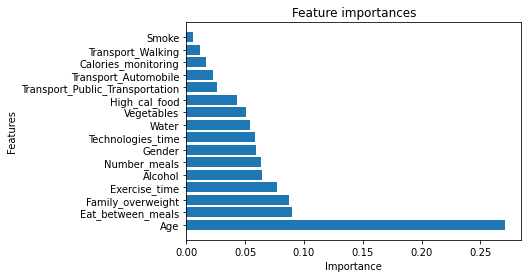

In [4]:
plt.barh(importances.Column, importances.Importance)
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Models with 4 categories

Let's explore first the models with 4 categories in the target variable and with all the features. 

## Models with all the features

### Decision tree

In [5]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'splitter': ['best', 'random']}

dt = DecisionTreeClassifier(random_state = 1)
grid_search_dt = GridSearchCV(estimator = dt, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_dt.fit(X_train, y_train)
print(grid_search_dt.best_params_)

best_grid_dt = grid_search_dt.best_estimator_
y_pred_dt = best_grid_dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))

Fitting 4 folds for each of 84 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.0s


{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'splitter': 'best'}
                     precision    recall  f1-score   support

Insufficient_Weight       0.65      0.76      0.70        54
      Normal_Weight       0.50      0.48      0.49        58
            Obesity       0.85      0.82      0.83       195
         Overweight       0.65      0.65      0.65       116

           accuracy                           0.72       423
          macro avg       0.66      0.68      0.67       423
       weighted avg       0.72      0.72      0.72       423



[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    2.3s finished


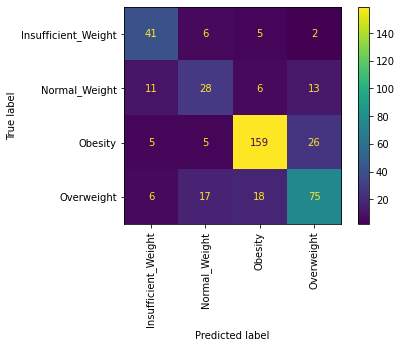

In [6]:
plot_confusion_matrix(best_grid_dt, X_test, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Random forest

In [7]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [100, 250, 500]}

rf = RandomForestClassifier(random_state = 1)
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_rf.fit(X_train, y_train)
print(grid_search_rf.best_params_)

best_grid_rf = grid_search_rf.best_estimator_
y_pred_rf = best_grid_rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 4 folds for each of 126 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   32.0s finished


{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.93      0.92        54
      Normal_Weight       0.72      0.62      0.67        58
            Obesity       0.80      0.96      0.87       195
         Overweight       0.82      0.59      0.69       116

           accuracy                           0.81       423
          macro avg       0.81      0.78      0.79       423
       weighted avg       0.81      0.81      0.80       423



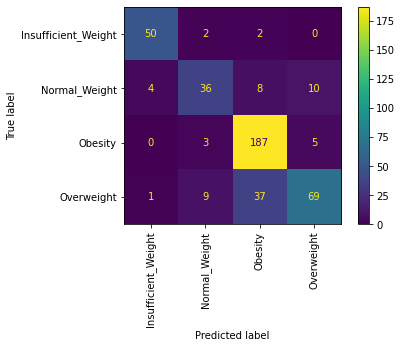

In [8]:
plot_confusion_matrix(best_grid_rf, X_test, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Gradient Boosting

In [9]:
param_grid = {'n_estimators': [50, 100, 150, 200],
              'learning_rate': [0.2, 0.4, 0.5, 0.7, 1],
              'max_depth': [2, 3, 4, 5, 6, 7, 8]}

gbc = GradientBoostingClassifier(random_state = 1)
grid_search_gbc = GridSearchCV(estimator = gbc, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_gbc.fit(X_train, y_train)
print(grid_search_gbc.best_params_)

best_grid_gbc = grid_search_gbc.best_estimator_
y_pred_gbc = best_grid_gbc.predict(X_test)

print(classification_report(y_test, y_pred_gbc))

Fitting 4 folds for each of 140 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  1.9min finished


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.91      0.91        54
      Normal_Weight       0.64      0.64      0.64        58
            Obesity       0.88      0.90      0.89       195
         Overweight       0.77      0.74      0.76       116

           accuracy                           0.82       423
          macro avg       0.80      0.80      0.80       423
       weighted avg       0.82      0.82      0.82       423



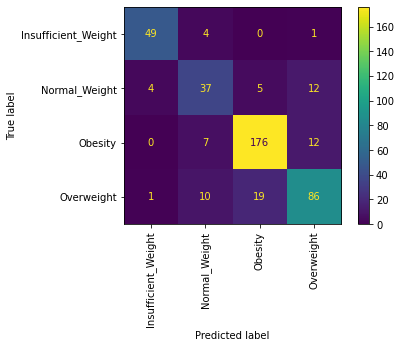

In [10]:
plot_confusion_matrix(best_grid_gbc, X_test, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### AdaBoost

In [11]:
param_grid = {'n_estimators': [50, 100, 250, 500],
              'learning_rate': [0.25, 0.5, 0.75, 1],
              'algorithm': ['SAMME', 'SAMME.R']}

ada = AdaBoostClassifier(base_estimator = best_grid_dt, random_state = 1)
grid_search_ada = GridSearchCV(estimator = ada, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_ada.fit(X_train, y_train)
print(grid_search_ada.best_params_)

best_grid_ada = grid_search_ada.best_estimator_
y_pred_ada = best_grid_ada.predict(X_test)

print(classification_report(y_test, y_pred_ada))

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.8s


{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 50}
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.91      0.92        54
      Normal_Weight       0.76      0.64      0.69        58
            Obesity       0.90      0.94      0.92       195
         Overweight       0.79      0.80      0.79       116

           accuracy                           0.86       423
          macro avg       0.84      0.82      0.83       423
       weighted avg       0.85      0.86      0.85       423



[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   15.0s finished


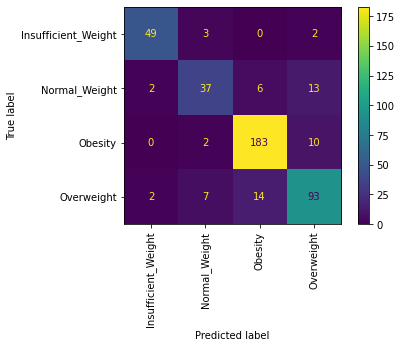

In [12]:
plot_confusion_matrix(best_grid_ada, X_test, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Voting classifier hard

In [13]:
clf1 = best_grid_ada
clf2 = best_grid_gbc
clf3 = best_grid_rf

eclf_hard = VotingClassifier(estimators = [('ada', clf1), ('gbc', clf2), ('rfc', clf3)], voting = 'hard')
eclf_hard = eclf_hard.fit(X_train, y_train)

y_pred_eclf_hard = eclf_hard.predict(X_test)

print(classification_report(y_test, y_pred_eclf_hard))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.93        54
      Normal_Weight       0.71      0.71      0.71        58
            Obesity       0.88      0.93      0.90       195
         Overweight       0.81      0.72      0.76       116

           accuracy                           0.84       423
          macro avg       0.83      0.82      0.83       423
       weighted avg       0.84      0.84      0.84       423



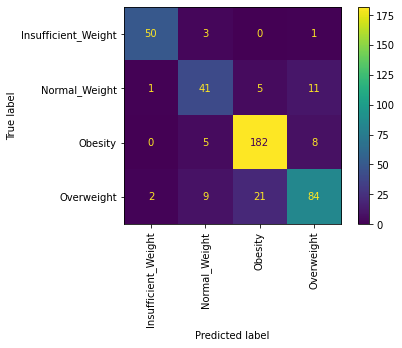

In [14]:
plot_confusion_matrix(eclf_hard, X_test, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Voting classifier soft

In [15]:
clf1 = best_grid_ada
clf2 = best_grid_gbc
clf3 = best_grid_rf

eclf_soft = VotingClassifier(estimators = [('ada', clf1), ('gbc', clf2), ('rfc', clf3)], voting = 'soft')
eclf_soft = eclf_soft.fit(X_train, y_train)

y_pred_eclf_soft = eclf_soft.predict(X_test)

print(classification_report(y_test, y_pred_eclf_soft))

                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.91      0.91        54
      Normal_Weight       0.67      0.64      0.65        58
            Obesity       0.88      0.92      0.90       195
         Overweight       0.81      0.77      0.79       116

           accuracy                           0.84       423
          macro avg       0.82      0.81      0.81       423
       weighted avg       0.83      0.84      0.84       423



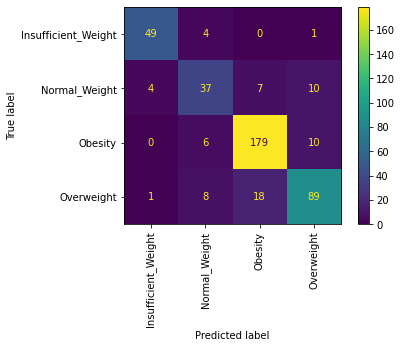

In [16]:
plot_confusion_matrix(eclf_soft, X_test, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

## Models with less features

Let's train the models with 4 categories in the target variable and without the three less important features.

In [17]:
X_train_less = X_train.drop(['Transport_Automobile', 'Transport_Public_Transportation', 'Transport_Walking', 'Smoke', 'Calories_monitoring'], axis = 1)
X_test_less = X_test.drop(['Transport_Automobile', 'Transport_Public_Transportation', 'Transport_Walking', 'Smoke', 'Calories_monitoring'], axis = 1)

### Decision tree

In [18]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'splitter': ['best', 'random']}

dt_2 = DecisionTreeClassifier(random_state = 1)
grid_search_dt_2 = GridSearchCV(estimator = dt_2, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_dt_2.fit(X_train_less, y_train)
print(grid_search_dt_2.best_params_)

best_grid_dt_2 = grid_search_dt_2.best_estimator_
y_pred_dt_2 = best_grid_dt_2.predict(X_test_less)

print(classification_report(y_test, y_pred_dt_2))

Fitting 4 folds for each of 84 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s


{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'splitter': 'best'}
                     precision    recall  f1-score   support

Insufficient_Weight       0.76      0.69      0.72        54
      Normal_Weight       0.52      0.45      0.48        58
            Obesity       0.76      0.90      0.83       195
         Overweight       0.63      0.51      0.56       116

           accuracy                           0.70       423
          macro avg       0.67      0.64      0.65       423
       weighted avg       0.69      0.70      0.69       423



[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.3s finished


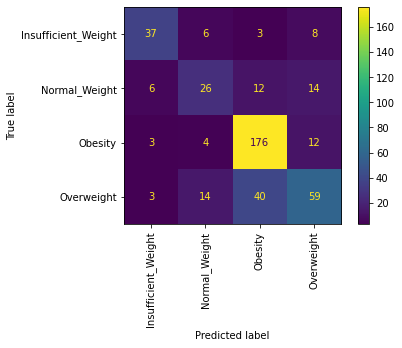

In [19]:
plot_confusion_matrix(best_grid_dt_2, X_test_less, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Random forest

In [20]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [100, 250, 500]}

rf_2 = RandomForestClassifier(random_state = 1)
grid_search_rf_2 = GridSearchCV(estimator = rf_2, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_rf_2.fit(X_train_less, y_train)
print(grid_search_rf_2.best_params_)

best_grid_rf_2 = grid_search_rf_2.best_estimator_
y_pred_rf_2 = best_grid_rf_2.predict(X_test_less)

print(classification_report(y_test, y_pred_rf_2))

Fitting 4 folds for each of 126 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   37.2s finished


{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.93      0.92        54
      Normal_Weight       0.72      0.57      0.63        58
            Obesity       0.82      0.95      0.88       195
         Overweight       0.81      0.66      0.72       116

           accuracy                           0.82       423
          macro avg       0.81      0.78      0.79       423
       weighted avg       0.81      0.82      0.81       423



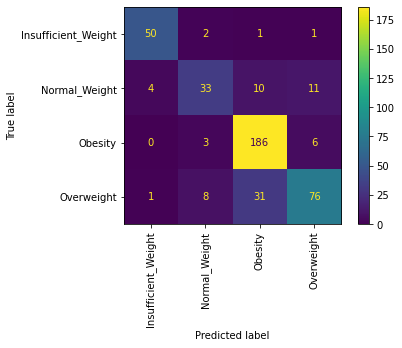

In [21]:
plot_confusion_matrix(best_grid_rf_2, X_test_less, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Gradient Boosting

In [22]:
param_grid = {'n_estimators': [50, 100, 150, 200],
              'learning_rate': [0.2, 0.4, 0.5, 0.7, 1],
              'max_depth': [2, 3, 4, 5, 6, 7, 8]}

gbc_2 = GradientBoostingClassifier(random_state = 1)
grid_search_gbc_2 = GridSearchCV(estimator = gbc_2, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_gbc_2.fit(X_train_less, y_train)
print(grid_search_gbc_2.best_params_)

best_grid_gbc_2 = grid_search_gbc_2.best_estimator_
y_pred_gbc_2 = best_grid_gbc_2.predict(X_test_less)

print(classification_report(y_test, y_pred_gbc_2))

Fitting 4 folds for each of 140 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  1.9min finished


{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.91      0.93        54
      Normal_Weight       0.66      0.67      0.67        58
            Obesity       0.86      0.89      0.87       195
         Overweight       0.73      0.70      0.71       116

           accuracy                           0.81       423
          macro avg       0.80      0.79      0.80       423
       weighted avg       0.81      0.81      0.81       423



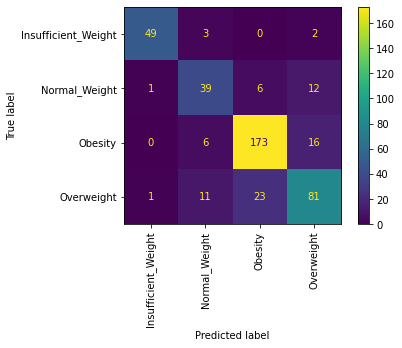

In [23]:
plot_confusion_matrix(best_grid_gbc_2, X_test_less, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### AdaBoost

In [24]:
param_grid = {'n_estimators': [50, 100, 250, 500],
              'learning_rate': [0.25, 0.5, 0.75, 1],
              'algorithm': ['SAMME', 'SAMME.R']}

ada_2 = AdaBoostClassifier(base_estimator = best_grid_dt_2, random_state = 1)
grid_search_ada_2 = GridSearchCV(estimator = ada_2, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_ada_2.fit(X_train_less, y_train)
print(grid_search_ada_2.best_params_)

best_grid_ada_2 = grid_search_ada_2.best_estimator_
y_pred_ada_2 = best_grid_ada_2.predict(X_test_less)

print(classification_report(y_test, y_pred_ada_2))

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   14.7s finished


{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 100}
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.85      0.88        54
      Normal_Weight       0.66      0.53      0.59        58
            Obesity       0.88      0.93      0.90       195
         Overweight       0.77      0.79      0.78       116

           accuracy                           0.83       423
          macro avg       0.81      0.78      0.79       423
       weighted avg       0.82      0.83      0.82       423



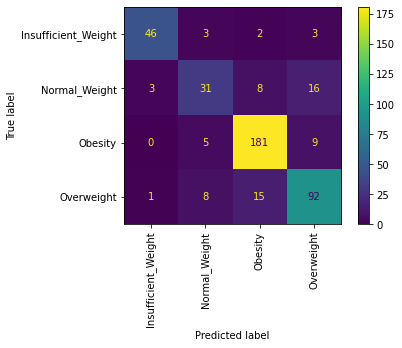

In [25]:
plot_confusion_matrix(best_grid_ada_2, X_test_less, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Voting classifier hard

In [26]:
clf1_2 = best_grid_ada_2
clf2_2 = best_grid_gbc_2
clf3_2 = best_grid_rf_2

eclf_hard_2 = VotingClassifier(estimators = [('ada', clf1_2), ('gbc', clf2_2), ('rfc', clf3_2)], voting = 'hard')
eclf_hard_2 = eclf_hard_2.fit(X_train_less, y_train)

y_pred_eclf_hard_2 = eclf_hard_2.predict(X_test_less)

print(classification_report(y_test, y_pred_eclf_hard_2))

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.93      0.94        54
      Normal_Weight       0.68      0.66      0.67        58
            Obesity       0.87      0.93      0.90       195
         Overweight       0.80      0.73      0.77       116

           accuracy                           0.84       423
          macro avg       0.83      0.81      0.82       423
       weighted avg       0.83      0.84      0.83       423



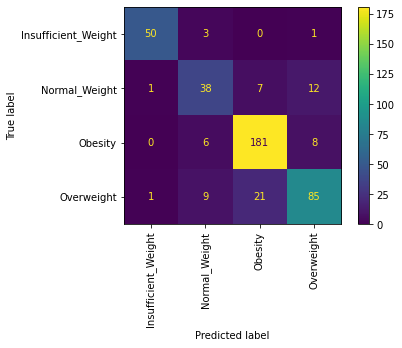

In [27]:
plot_confusion_matrix(eclf_hard_2, X_test_less, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Voting classifier soft

In [28]:
clf1_2 = best_grid_ada_2
clf2_2 = best_grid_gbc_2
clf3_2 = best_grid_rf_2

eclf_soft_2 = VotingClassifier(estimators = [('ada', clf1_2), ('gbc', clf2_2), ('rfc', clf3_2)], voting = 'soft')
eclf_soft_2 = eclf_soft_2.fit(X_train_less, y_train)

y_pred_eclf_soft_2 = eclf_soft_2.predict(X_test_less)

print(classification_report(y_test, y_pred_eclf_soft_2))

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.91      0.93        54
      Normal_Weight       0.69      0.62      0.65        58
            Obesity       0.85      0.91      0.88       195
         Overweight       0.74      0.72      0.73       116

           accuracy                           0.82       423
          macro avg       0.81      0.79      0.80       423
       weighted avg       0.81      0.82      0.81       423



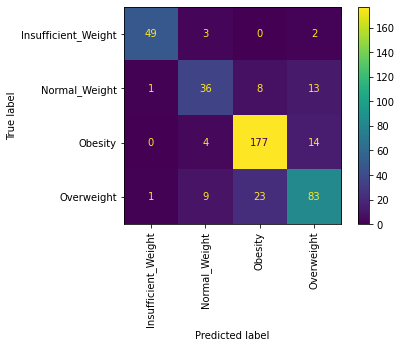

In [29]:
plot_confusion_matrix(eclf_soft_2, X_test_less, y_test,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

## 4 categories resume

In [59]:
four_cat_res = pd.DataFrame({'Model': ['Decision tree', 'Random forest', 'Gradient boosting', 'AdaBoost',
                                      'Voting classifier hard', 'Voting classifier soft'],
                             'All features accuracy': [0.72, 0.81, 0.82, 0.86, 0.84, 0.84],
                             'Less features accuracy': [0.70, 0.82, 0.81, 0.83, 0.84, 0.82]})
four_cat_res

,Model,All features accuracy,Less features accuracy
0,Decision tree,0.72,0.70
1,Random forest,0.81,0.82
2,Gradient boosting,0.82,0.81
3,AdaBoost,0.86,0.83
4,Voting classifier hard,0.84,0.84
5,Voting classifier soft,0.84,0.82


# Models with 3 categories

Let's explore now the models with 3 categories in the target variable and with all the features. 

In [31]:
new_data = data.copy()
new_data.NObeyesdad = new_data.NObeyesdad.apply(lambda x: 'Infra-Normal_weight' if x in ['Insufficient_Weight', 'Normal_Weight'] else x)
new_data['NObeyesdad'] = pd.Categorical(new_data['NObeyesdad'], categories = ['Infra-Normal_weight', 'Overweight', 'Obesity'])
new_data

,Gender,Age,Family_overweight,High_cal_food,Vegetables,Number_meals,Eat_between_meals,Smoke,Water,Calories_monitoring,Exercise_time,Technologies_time,Alcohol,NObeyesdad,Transport_Automobile,Transport_Public_Transportation,Transport_Walking
0,1,21.000000,1,0,1,1,1,0,1,0,0,1,0,Infra-Normal_weight,0,1,0
1,1,21.000000,1,0,2,1,1,1,2,1,3,0,1,Infra-Normal_weight,0,1,0
2,0,23.000000,1,0,1,1,1,0,1,0,2,1,2,Infra-Normal_weight,0,1,0
3,0,27.000000,0,0,2,1,1,0,1,0,2,0,2,Overweight,0,0,1
4,0,22.000000,0,0,1,0,1,0,1,0,0,0,1,Overweight,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20.976842,1,1,2,1,1,0,1,0,2,1,1,Obesity,0,1,0
2107,1,21.982942,1,1,2,1,1,0,1,0,1,1,1,Obesity,0,1,0
2108,1,22.524036,1,1,2,1,1,0,1,0,1,1,1,Obesity,0,1,0
2109,1,24.361936,1,1,2,1,1,0,2,0,1,1,1,Obesity,0,1,0


In [32]:
X_2 = new_data.drop('NObeyesdad', axis = 1)
y_2 = new_data.iloc[:, -4]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.2, stratify = y_2, random_state = 123)

## Models with all the features

### Decision tree

In [33]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'splitter': ['best', 'random']}

dt_3 = DecisionTreeClassifier(random_state = 1)
grid_search_dt_3 = GridSearchCV(estimator = dt_3, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_dt_3.fit(X_train_2, y_train_2)
print(grid_search_dt_3.best_params_)

best_grid_dt_3 = grid_search_dt_3.best_estimator_
y_pred_dt_3 = best_grid_dt_3.predict(X_test_2)

print(classification_report(y_test_2, y_pred_dt_3))

Fitting 4 folds for each of 84 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s


{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'splitter': 'best'}
                     precision    recall  f1-score   support

Infra-Normal_weight       0.78      0.71      0.74       112
            Obesity       0.84      0.79      0.82       195
         Overweight       0.62      0.72      0.67       116

           accuracy                           0.75       423
          macro avg       0.75      0.74      0.74       423
       weighted avg       0.76      0.75      0.76       423



[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.4s finished


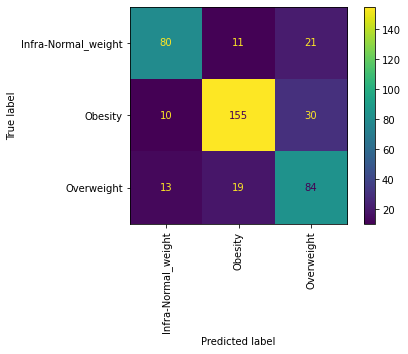

In [34]:
plot_confusion_matrix(best_grid_dt_3, X_test_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Random forest

In [35]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [100, 250, 500]}

rf_3 = RandomForestClassifier(random_state = 1)
grid_search_rf_3 = GridSearchCV(estimator = rf_3, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_rf_3.fit(X_train_2, y_train_2)
print(grid_search_rf_3.best_params_)

best_grid_rf_3 = grid_search_rf_3.best_estimator_
y_pred_rf_3 = best_grid_rf_3.predict(X_test_2)

print(classification_report(y_test_2, y_pred_rf_3))

Fitting 4 folds for each of 126 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   38.4s finished


{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 250}
                     precision    recall  f1-score   support

Infra-Normal_weight       0.88      0.85      0.86       112
            Obesity       0.81      0.95      0.87       195
         Overweight       0.85      0.61      0.71       116

           accuracy                           0.83       423
          macro avg       0.84      0.80      0.82       423
       weighted avg       0.84      0.83      0.83       423



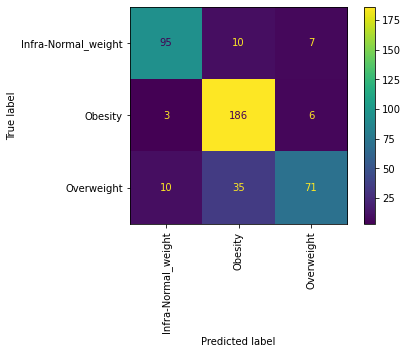

In [36]:
plot_confusion_matrix(best_grid_rf_3, X_test_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Gradient Boosting

In [37]:
param_grid = {'n_estimators': [50, 100, 150, 200],
              'learning_rate': [0.2, 0.4, 0.5, 0.7, 1],
              'max_depth': [2, 3, 4, 5, 6, 7, 8]}

gbc_3 = GradientBoostingClassifier(random_state = 1)
grid_search_gbc_3 = GridSearchCV(estimator = gbc_3, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_gbc_3.fit(X_train_2, y_train_2)
print(grid_search_gbc_3.best_params_)

best_grid_gbc_3 = grid_search_gbc_3.best_estimator_
y_pred_gbc_3 = best_grid_gbc_3.predict(X_test_2)

print(classification_report(y_test_2, y_pred_gbc_3))

Fitting 4 folds for each of 140 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  1.5min finished


{'learning_rate': 0.7, 'max_depth': 7, 'n_estimators': 50}
                     precision    recall  f1-score   support

Infra-Normal_weight       0.86      0.83      0.85       112
            Obesity       0.88      0.92      0.90       195
         Overweight       0.80      0.78      0.79       116

           accuracy                           0.86       423
          macro avg       0.85      0.84      0.84       423
       weighted avg       0.85      0.86      0.86       423



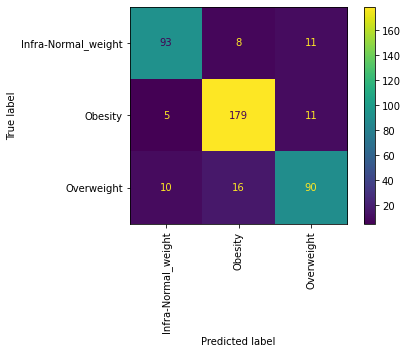

In [38]:
plot_confusion_matrix(best_grid_gbc_3, X_test_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### AdaBoost

In [39]:
param_grid = {'n_estimators': [50, 100, 250, 500],
              'learning_rate': [0.25, 0.5, 0.75, 1],
              'algorithm': ['SAMME', 'SAMME.R']}

ada_3 = AdaBoostClassifier(base_estimator = best_grid_dt_3, random_state = 1)
grid_search_ada_3 = GridSearchCV(estimator = ada_3, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_ada_3.fit(X_train_2, y_train_2)
print(grid_search_ada_3.best_params_)

best_grid_ada_3 = grid_search_ada_3.best_estimator_
y_pred_ada_3 = best_grid_ada_3.predict(X_test_2)

print(classification_report(y_test_2, y_pred_ada_3))

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.5s


{'algorithm': 'SAMME', 'learning_rate': 0.25, 'n_estimators': 50}
                     precision    recall  f1-score   support

Infra-Normal_weight       0.85      0.83      0.84       112
            Obesity       0.89      0.91      0.90       195
         Overweight       0.80      0.78      0.79       116

           accuracy                           0.86       423
          macro avg       0.85      0.84      0.84       423
       weighted avg       0.86      0.86      0.86       423



[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   14.4s finished


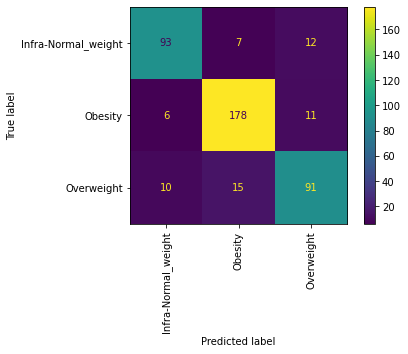

In [40]:
plot_confusion_matrix(best_grid_ada_3, X_test_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Voting classifier hard


In [41]:
clf1_3 = best_grid_ada_3
clf2_3 = best_grid_gbc_3
clf3_3 = best_grid_rf_3

eclf_hard_3 = VotingClassifier(estimators = [('ada', clf1_3), ('gbc', clf2_3), ('rfc', clf3_3)], voting = 'hard')
eclf_hard_3 = eclf_hard_3.fit(X_train_2, y_train_2)

y_pred_eclf_hard_3 = eclf_hard_3.predict(X_test_2)

print(classification_report(y_test_2, y_pred_eclf_hard_3))

                     precision    recall  f1-score   support

Infra-Normal_weight       0.87      0.88      0.87       112
            Obesity       0.88      0.93      0.91       195
         Overweight       0.84      0.75      0.79       116

           accuracy                           0.87       423
          macro avg       0.86      0.85      0.86       423
       weighted avg       0.87      0.87      0.87       423



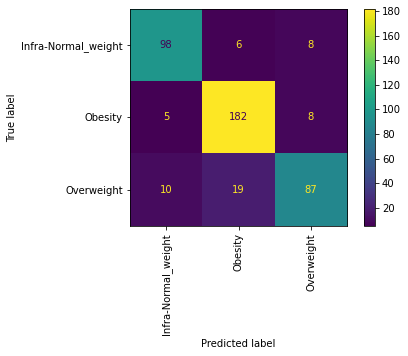

In [42]:
plot_confusion_matrix(eclf_hard_3, X_test_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Voting classifier soft


In [43]:
clf1_3 = best_grid_ada_3
clf2_3 = best_grid_gbc_3
clf3_3 = best_grid_rf_3

eclf_soft_3 = VotingClassifier(estimators = [('ada', clf1_3), ('gbc', clf2_3), ('rfc', clf3_3)], voting = 'soft')
eclf_soft_3 = eclf_soft_3.fit(X_train_2, y_train_2)

y_pred_eclf_soft_3 = eclf_soft_3.predict(X_test_2)

print(classification_report(y_test_2, y_pred_eclf_soft_3))

                     precision    recall  f1-score   support

Infra-Normal_weight       0.88      0.86      0.87       112
            Obesity       0.90      0.93      0.91       195
         Overweight       0.83      0.80      0.82       116

           accuracy                           0.87       423
          macro avg       0.87      0.86      0.87       423
       weighted avg       0.87      0.87      0.87       423



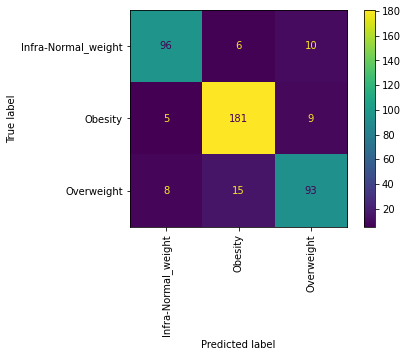

In [44]:
plot_confusion_matrix(eclf_soft_3, X_test_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

## Models with less features

Let's train the models with 3 categories in the target variable and without the three less important features.

In [45]:
X_train_less_2 = X_train_2.drop(['Transport_Automobile', 'Transport_Public_Transportation', 'Transport_Walking', 'Smoke', 
                                 'Calories_monitoring'], axis = 1)
X_test_less_2 = X_test_2.drop(['Transport_Automobile', 'Transport_Public_Transportation', 'Transport_Walking', 'Smoke', 
                               'Calories_monitoring'], axis = 1)

### Decision tree

In [46]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'splitter': ['best', 'random']}

dt_4 = DecisionTreeClassifier(random_state = 1)
grid_search_dt_4 = GridSearchCV(estimator = dt_4, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_dt_4.fit(X_train_less_2, y_train_2)
print(grid_search_dt_4.best_params_)

best_grid_dt_4 = grid_search_dt_4.best_estimator_
y_pred_dt_4 = best_grid_dt_4.predict(X_test_less_2)

print(classification_report(y_test_2, y_pred_dt_4))

Fitting 4 folds for each of 84 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s


{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'splitter': 'best'}
                     precision    recall  f1-score   support

Infra-Normal_weight       0.81      0.69      0.74       112
            Obesity       0.79      0.91      0.85       195
         Overweight       0.64      0.58      0.61       116

           accuracy                           0.76       423
          macro avg       0.75      0.72      0.73       423
       weighted avg       0.76      0.76      0.75       423



[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    0.3s finished


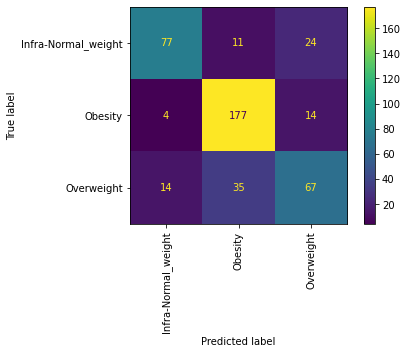

In [47]:
plot_confusion_matrix(best_grid_dt_4, X_test_less_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Random forest

In [48]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6, 8, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [100, 250, 500]}

rf_4 = RandomForestClassifier(random_state = 1)
grid_search_rf_4 = GridSearchCV(estimator = rf_4, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_rf_4.fit(X_train_less_2, y_train_2)
print(grid_search_rf_4.best_params_)

best_grid_rf_4 = grid_search_rf_4.best_estimator_
y_pred_rf_4 = best_grid_rf_4.predict(X_test_less_2)

print(classification_report(y_test_2, y_pred_rf_4))

Fitting 4 folds for each of 126 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   19.0s


{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
                     precision    recall  f1-score   support

Infra-Normal_weight       0.88      0.83      0.85       112
            Obesity       0.86      0.95      0.90       195
         Overweight       0.80      0.71      0.75       116

           accuracy                           0.85       423
          macro avg       0.85      0.83      0.84       423
       weighted avg       0.85      0.85      0.85       423



[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   38.3s finished


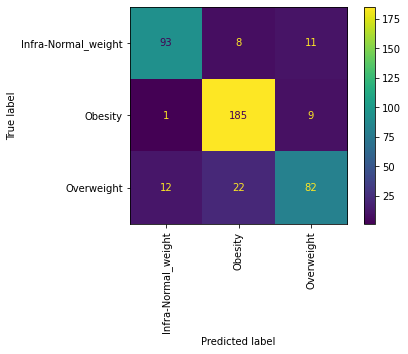

In [49]:
plot_confusion_matrix(best_grid_rf_4, X_test_less_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show() 

### Gradient Boosting

In [50]:
param_grid = {'n_estimators': [50, 100, 150, 200],
              'learning_rate': [0.2, 0.4, 0.5, 0.7, 1],
              'max_depth': [2, 3, 4, 5, 6, 7, 8]}

gbc_4 = GradientBoostingClassifier(random_state = 1)
grid_search_gbc_4 = GridSearchCV(estimator = gbc_4, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_gbc_4.fit(X_train_less_2, y_train_2)
print(grid_search_gbc_4.best_params_)

best_grid_gbc_4 = grid_search_gbc_4.best_estimator_
y_pred_gbc_4 = best_grid_gbc_4.predict(X_test_less_2)

print(classification_report(y_test_2, y_pred_gbc_4))

Fitting 4 folds for each of 140 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  1.4min finished


{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
                     precision    recall  f1-score   support

Infra-Normal_weight       0.86      0.85      0.86       112
            Obesity       0.89      0.91      0.90       195
         Overweight       0.80      0.78      0.79       116

           accuracy                           0.86       423
          macro avg       0.85      0.85      0.85       423
       weighted avg       0.86      0.86      0.86       423



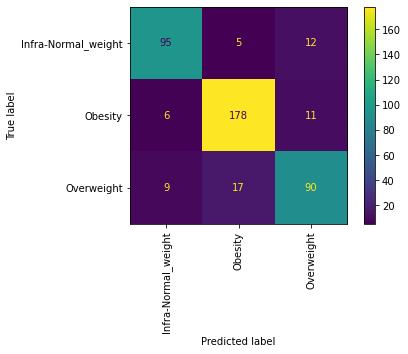

In [51]:
plot_confusion_matrix(best_grid_gbc_4, X_test_less_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### AdaBoost

In [52]:
param_grid = {'n_estimators': [50, 100, 250, 500],
              'learning_rate': [0.25, 0.5, 0.75, 1],
              'algorithm': ['SAMME', 'SAMME.R']}

ada_4 = AdaBoostClassifier(base_estimator = best_grid_dt_4, random_state = 1)
grid_search_ada_4 = GridSearchCV(estimator = ada_4, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 3)
grid_search_ada_4.fit(X_train_less_2, y_train_2)
print(grid_search_ada_4.best_params_)

best_grid_ada_4 = grid_search_ada_4.best_estimator_
y_pred_ada_4 = best_grid_ada_4.predict(X_test_less_2)

print(classification_report(y_test_2, y_pred_ada_4))

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   14.1s finished


{'algorithm': 'SAMME', 'learning_rate': 0.25, 'n_estimators': 100}
                     precision    recall  f1-score   support

Infra-Normal_weight       0.86      0.80      0.83       112
            Obesity       0.91      0.93      0.92       195
         Overweight       0.79      0.80      0.80       116

           accuracy                           0.86       423
          macro avg       0.85      0.85      0.85       423
       weighted avg       0.86      0.86      0.86       423



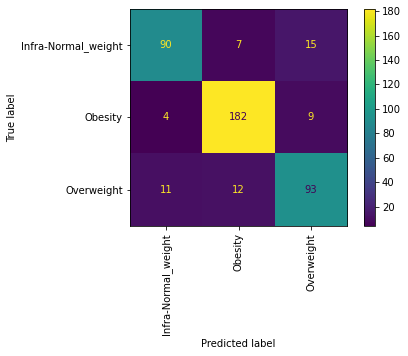

In [53]:
plot_confusion_matrix(best_grid_ada_4, X_test_less_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Voting classifier hard


In [54]:
clf1_4 = best_grid_ada_4
clf2_4 = best_grid_gbc_4
clf3_4 = best_grid_rf_4

eclf_hard_4 = VotingClassifier(estimators = [('ada', clf1_4), ('gbc', clf2_4), ('rfc', clf3_4)], voting = 'hard')
eclf_hard_4 = eclf_hard_4.fit(X_train_less_2, y_train_2)

y_pred_eclf_hard_4 = eclf_hard_4.predict(X_test_less_2)

print(classification_report(y_test_2, y_pred_eclf_hard_4))

                     precision    recall  f1-score   support

Infra-Normal_weight       0.84      0.84      0.84       112
            Obesity       0.90      0.93      0.91       195
         Overweight       0.82      0.77      0.79       116

           accuracy                           0.86       423
          macro avg       0.85      0.85      0.85       423
       weighted avg       0.86      0.86      0.86       423



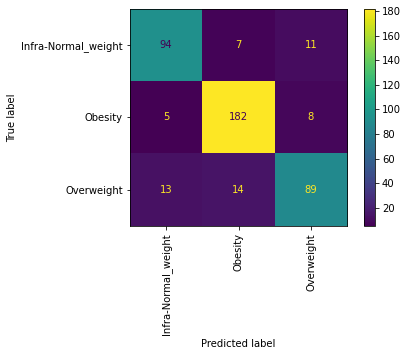

In [55]:
plot_confusion_matrix(eclf_hard_4, X_test_less_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

### Voting classifier soft

In [56]:
clf1_4 = best_grid_ada_4
clf2_4 = best_grid_gbc_4
clf3_4 = best_grid_rf_4

eclf_soft_4 = VotingClassifier(estimators = [('ada', clf1_4), ('gbc', clf2_4), ('rfc', clf3_4)], voting = 'soft')
eclf_soft_4 = eclf_soft_4.fit(X_train_less_2, y_train_2)

y_pred_eclf_soft_4 = eclf_soft_4.predict(X_test_less_2)

print(classification_report(y_test_2, y_pred_eclf_soft_4))

                     precision    recall  f1-score   support

Infra-Normal_weight       0.89      0.85      0.87       112
            Obesity       0.88      0.93      0.91       195
         Overweight       0.83      0.78      0.80       116

           accuracy                           0.87       423
          macro avg       0.86      0.85      0.86       423
       weighted avg       0.87      0.87      0.87       423



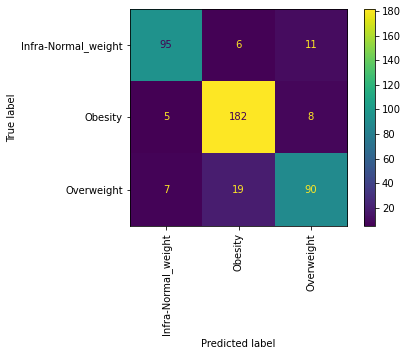

In [57]:
plot_confusion_matrix(eclf_soft_4, X_test_less_2, y_test_2,  xticks_rotation = 'vertical', values_format = 'd')
plt.show()

## 3 categories resume

In [60]:
three_cat_res = pd.DataFrame({'Model': ['Decision tree', 'Random forest', 'Gradient boosting', 'AdaBoost',
                                      'Voting classifier hard', 'Voting classifier soft'],
                             'All features accuracy': [0.75, 0.83, 0.86, 0.86, 0.87, 0.87],
                             'Less features accuracy': [0.76, 0.85, 0.86, 0.86, 0.86, 0.87]})
three_cat_res

,Model,All features accuracy,Less features accuracy
0,Decision tree,0.75,0.76
1,Random forest,0.83,0.85
2,Gradient boosting,0.86,0.86
3,AdaBoost,0.86,0.86
4,Voting classifier hard,0.87,0.86
5,Voting classifier soft,0.87,0.87
